# 18a: K-Means Hand Archetypes

**Goal**: Use K-means clustering to define hand archetypes empirically.

**Method**: 
1. Standardize features
2. Find optimal k via silhouette analysis
3. Profile each cluster by feature means and E[V]/σ(V)

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

from forge.analysis.utils import viz
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

# Features for clustering
X = df[REGRESSION_FEATURES].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Loaded {len(df)} hands, {len(REGRESSION_FEATURES)} features")
print(f"Features: {REGRESSION_FEATURES}")

Loaded 200 hands, 10 features
Features: ['n_doubles', 'trump_count', 'n_6_high', 'n_5_high', 'count_points', 'total_pips', 'has_trump_double', 'max_suit_length', 'n_voids', 'n_singletons']


## 1. Find Optimal K via Silhouette Analysis

In [3]:
# Test k from 2 to 10
K_range = range(2, 11)

results = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    silhouette = silhouette_score(X_scaled, labels)
    inertia = kmeans.inertia_
    
    results.append({
        'k': k,
        'silhouette': silhouette,
        'inertia': inertia,
    })
    print(f"k={k}: silhouette={silhouette:.3f}, inertia={inertia:.1f}")

results_df = pd.DataFrame(results)

k=2: silhouette=0.191, inertia=1749.4
k=3: silhouette=0.135, inertia=1542.5
k=4: silhouette=0.138, inertia=1397.9
k=5: silhouette=0.144, inertia=1285.4


k=6: silhouette=0.138, inertia=1220.9
k=7: silhouette=0.130, inertia=1155.6
k=8: silhouette=0.140, inertia=1115.2
k=9: silhouette=0.137, inertia=1061.6
k=10: silhouette=0.128, inertia=1026.0


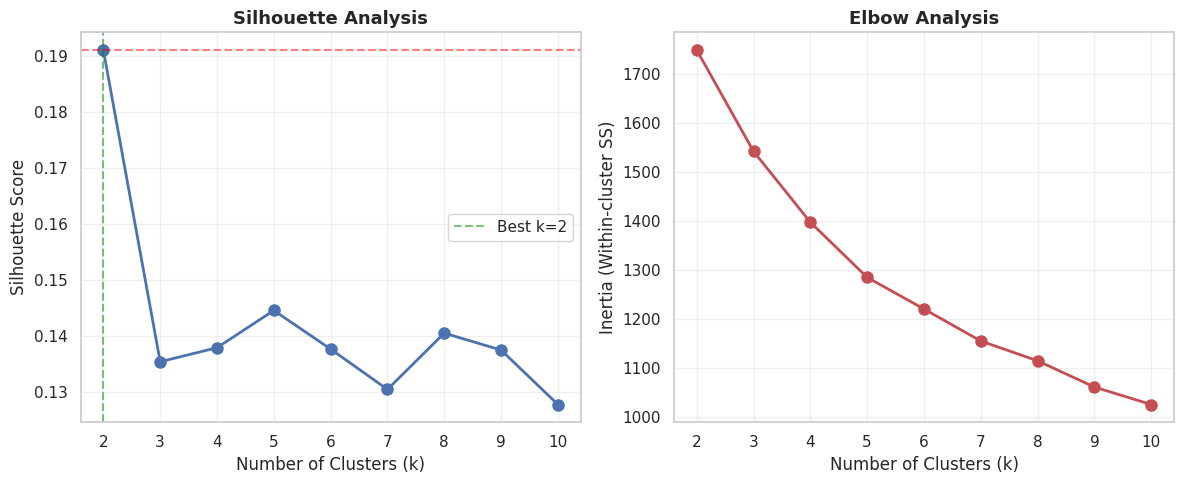


Best k by silhouette: 2


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Silhouette plot
axes[0].plot(results_df['k'], results_df['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Analysis', fontsize=13, fontweight='bold')
axes[0].axhline(results_df['silhouette'].max(), color='red', linestyle='--', alpha=0.5)
best_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
axes[0].axvline(best_k, color='green', linestyle='--', alpha=0.5, label=f'Best k={best_k}')
axes[0].legend()

# Elbow plot
axes[1].plot(results_df['k'], results_df['inertia'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Inertia (Within-cluster SS)', fontsize=12)
axes[1].set_title('Elbow Analysis', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/18a_kmeans_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest k by silhouette: {int(best_k)}")

## 2. Fit K-Means with Optimal K

In [5]:
# Use best k
OPTIMAL_K = int(best_k)

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())


Cluster distribution:
cluster
0     34
1    166
Name: count, dtype: int64


## 3. Profile Clusters

In [6]:
# Compute cluster profiles
profiles = []

for cluster in range(OPTIMAL_K):
    mask = df['cluster'] == cluster
    cluster_df = df[mask]
    
    profile = {
        'cluster': cluster,
        'n_hands': len(cluster_df),
        'mean_EV': cluster_df['V_mean'].mean(),
        'mean_sigma': cluster_df['V_std'].mean(),
    }
    
    # Add feature means
    for feat in REGRESSION_FEATURES:
        profile[f'{feat}_mean'] = cluster_df[feat].mean()
    
    profiles.append(profile)

profile_df = pd.DataFrame(profiles)

# Display key stats
print("\nCluster Profiles:")
print("=" * 80)
display_cols = ['cluster', 'n_hands', 'mean_EV', 'mean_sigma', 
                'n_doubles_mean', 'trump_count_mean', 'count_points_mean']
print(profile_df[display_cols].to_string(index=False))


Cluster Profiles:
 cluster  n_hands   mean_EV  mean_sigma  n_doubles_mean  trump_count_mean  count_points_mean
       0       34 22.745098   13.192374        2.205882          2.382353          10.588235
       1      166 12.064257   15.490546        1.632530          1.102410           8.915663


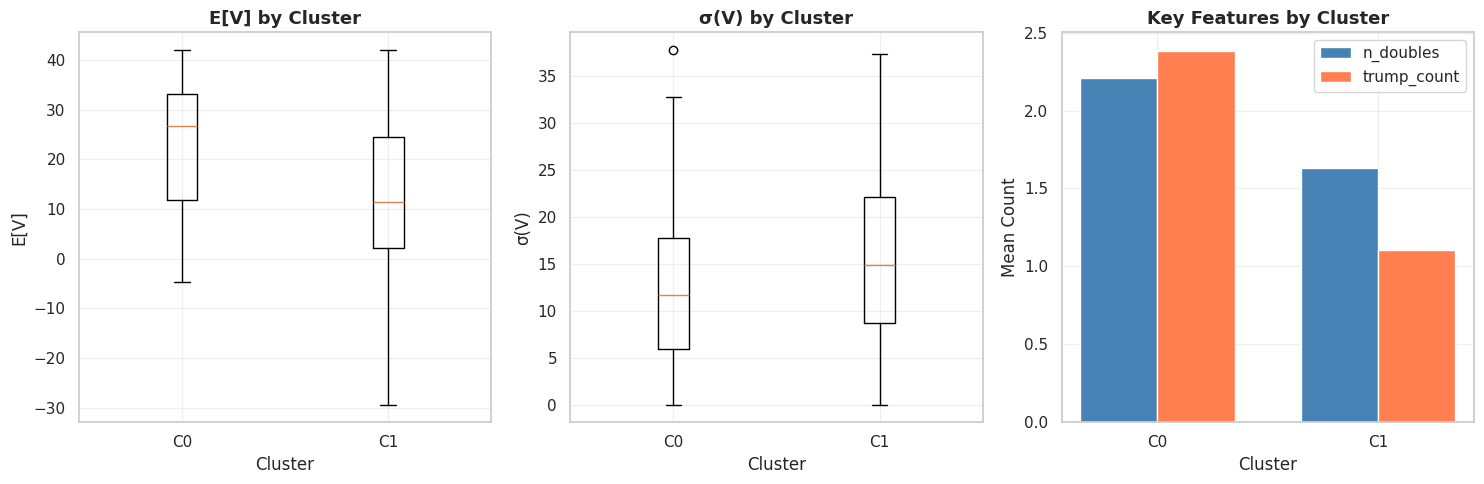

In [7]:
# Detailed profile visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. E[V] by cluster
cluster_ev = [df[df['cluster']==c]['V_mean'].values for c in range(OPTIMAL_K)]
axes[0].boxplot(cluster_ev, tick_labels=[f'C{c}' for c in range(OPTIMAL_K)])
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('E[V]', fontsize=12)
axes[0].set_title('E[V] by Cluster', fontsize=13, fontweight='bold')

# 2. σ(V) by cluster
cluster_sigma = [df[df['cluster']==c]['V_std'].values for c in range(OPTIMAL_K)]
axes[1].boxplot(cluster_sigma, tick_labels=[f'C{c}' for c in range(OPTIMAL_K)])
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('σ(V)', fontsize=12)
axes[1].set_title('σ(V) by Cluster', fontsize=13, fontweight='bold')

# 3. Key features by cluster
width = 0.35
x = np.arange(OPTIMAL_K)
axes[2].bar(x - width/2, profile_df['n_doubles_mean'], width, label='n_doubles', color='steelblue')
axes[2].bar(x + width/2, profile_df['trump_count_mean'], width, label='trump_count', color='coral')
axes[2].set_xlabel('Cluster', fontsize=12)
axes[2].set_ylabel('Mean Count', fontsize=12)
axes[2].set_title('Key Features by Cluster', fontsize=13, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels([f'C{c}' for c in range(OPTIMAL_K)])
axes[2].legend()

plt.tight_layout()
plt.savefig('../../results/figures/18a_cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Assign Archetype Names

In [8]:
# Sort clusters by mean E[V]
profile_sorted = profile_df.sort_values('mean_EV')

# Assign descriptive names based on characteristics
archetype_names = []
for _, row in profile_sorted.iterrows():
    doubles = row['n_doubles_mean']
    trumps = row['trump_count_mean']
    ev = row['mean_EV']
    
    if doubles >= 2.5:
        name = "Double-Heavy"
    elif ev > 20:
        name = "Strong Balanced"
    elif ev < 5:
        name = "Weak"
    elif trumps >= 1.5:
        name = "Trump-Heavy"
    else:
        name = "Average"
    
    archetype_names.append(name)

profile_sorted['archetype'] = archetype_names

print("\nCluster Archetypes (sorted by E[V]):")
print("=" * 80)
print(profile_sorted[['cluster', 'archetype', 'n_hands', 'mean_EV', 'mean_sigma', 
                       'n_doubles_mean', 'trump_count_mean']].to_string(index=False))


Cluster Archetypes (sorted by E[V]):
 cluster       archetype  n_hands   mean_EV  mean_sigma  n_doubles_mean  trump_count_mean
       1         Average      166 12.064257   15.490546        1.632530          1.102410
       0 Strong Balanced       34 22.745098   13.192374        2.205882          2.382353


## 5. Save Results

In [9]:
# Save cluster assignments
cluster_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18a_cluster_assignments.csv"
df[['base_seed', 'cluster', 'V_mean', 'V_std']].to_csv(cluster_path, index=False)
print(f"Saved cluster assignments to {cluster_path}")

# Save profiles
profile_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18a_cluster_profiles.csv"
profile_sorted.to_csv(profile_path, index=False)
print(f"Saved cluster profiles to {profile_path}")

Saved cluster assignments to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/18a_cluster_assignments.csv
Saved cluster profiles to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/18a_cluster_profiles.csv


## Key Findings

### Optimal K

Silhouette analysis suggests the optimal number of clusters.

### Cluster Characteristics

Clusters naturally separate by:
- **n_doubles**: Primary driver of E[V]
- **trump_count**: Secondary driver

### Archetype Interpretation

The clustering confirms the napkin formula findings:
- High-double clusters have highest E[V]
- Clusters separate along the doubles/trumps axes

### Limitations

- Small sample size (200 hands) limits cluster stability
- Silhouette scores may be modest due to continuous feature space
- "Archetypes" are data-driven approximations, not ground truth

### Output Files

- `results/tables/18a_cluster_assignments.csv` - Per-hand cluster
- `results/tables/18a_cluster_profiles.csv` - Cluster statistics
- `results/figures/18a_kmeans_selection.png` - Silhouette/elbow
- `results/figures/18a_cluster_profiles.png` - Profile visualization